# Overview
This notebook contains my exploration of the bakery sales data.

## Objectives
1. Understand changes in daily revenue for the timespan covered
    * Explain any anomalies using context (holidays, lockdowns, etc)
2. Calculate exact delivery fee for each transaction
    * Calculate item charges using counts and prices
    * Subtract item charge from total charges to determine delivery fee
3. Analyze delivery fee in the context of delivery location
    * Increased fees with longer delivery is probable
    * Are delivery fees associated with the 'place' or are they more specific?
    * Can we figure out 'close' and 'far' within a place just based on delivery fee differences?
4. Understand delivery locations and their trends
    * Do certain areas order during a certain time of day?
    * Do certain areas purchase more items on average?
    * Do certain areas purchase more in terms of revenue?
    * Did certain areas have increased/decreased activity weeks or months?
    * Do certain areas purchase more of an item than others?
5. Analyze how products sold
    * Which items sold the most?
    * Which items sold the least?
    * Which item had the highest revenue?
    * Are there significant increases or decreases in certain items sold during holidays or otherwise?
    * Are any items being disproportionately bought by certain areas?
6. Create a Tableau heatmap for locations and sales

## Findings

## Ideas
- Feature for each place (one-hot encoded for the transaction), so that day aggregation can also count number of orders from a place

# Pre-Exploration Checks
Imports...

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import wrangle

Prepare for exploration...

In [2]:
# wrangle data
sales, prices = wrangle.prep_explore()
daily_sales, non_rev_daily_sales = wrangle.drop_zero_rev_days(sales)

sales.shape, daily_sales.shape

((2294, 26), (297, 24))

Check univariate distributions of total revenues...

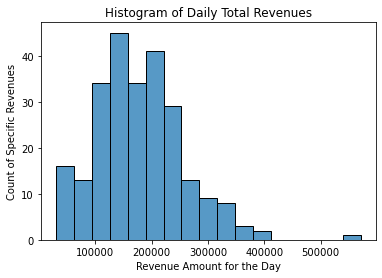

In [3]:
# plot histogram of daily revenue totals
sns.histplot(non_rev_daily_sales.total)
plt.title('Histogram of Daily Total Revenues')
plt.xlabel('Revenue Amount for the Day')
plt.ylabel('Count of Specific Revenues')
plt.show()

Check barplot for location counts...

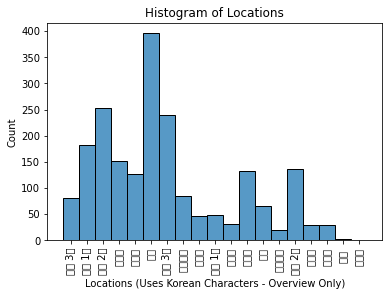

In [4]:
# barplot of location counts
sns.histplot(sales.place)
plt.title('Histogram of Locations')
plt.xlabel('Locations (Uses Korean Characters - Overview Only)')
plt.xticks(rotation=90)
plt.show()

Check univariate distributions of item counts...

In [5]:
# sum each item count column for categorical plot
total_item_counts = daily_sales.drop(columns='total').sum(axis=0)
total_counts_df = pd.DataFrame(total_item_counts, columns=['count'])

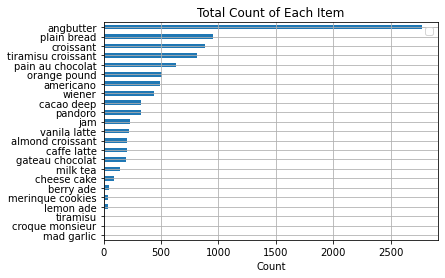

In [6]:
# plot each item's total count
total_counts_df.sort_values(by='count').plot.barh(grid=True)
plt.title('Total Count of Each Item')
plt.xlabel('Count')
plt.legend('')
plt.show()

Everything looks good, let's complete our objectives!

# 1. Understand changes in daily revenue for the timespan covered
1. Check moving averages to see periods of increased or decreases sales
2. Conduct domain research to see if observed changes are explainable
3. Conduct domain research to see if any events (in theory) should have an impact, but don't

## Average Sales by Day and Week

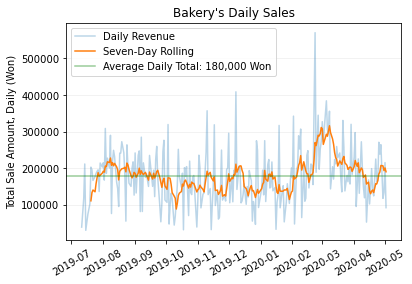

In [7]:
# 1. Check moving averages to see periods of increased or decreased sales
# plot daily sales (sum transaction totals)
plt.plot(non_rev_daily_sales[['total']], alpha=.3) # daily sales
plt.plot(non_rev_daily_sales[['total']].rolling(7).mean()) # overlay 7-day rolling average
plt.axhline(non_rev_daily_sales['total'].mean(), alpha=.4, c='green') # average daily total
plt.title("Bakery's Daily Sales")
plt.ylabel('Total Sale Amount, Daily (Won)')
plt.legend(['Daily Revenue', 'Seven-Day Rolling', 'Average Daily Total: 180,000 Won'])
plt.xticks(rotation=30)
plt.grid(axis='y', alpha=.2)
plt.show()

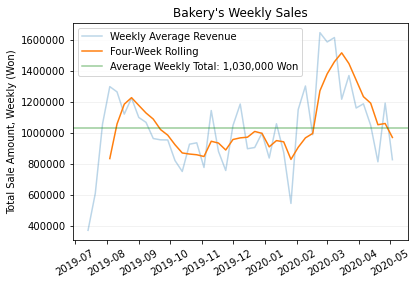

In [8]:
# plot weekly sales (sum transaction totals)
plt.plot(daily_sales[['total']].resample('W').sum(), alpha=.3) # weekly sales
plt.plot(daily_sales[['total']].resample('W').sum().rolling(4).mean()) # overlay 4-week rolling average
plt.axhline(daily_sales[['total']].resample('W').sum().total.mean(), alpha=.4, c='green') # average weekly total
plt.title("Bakery's Weekly Sales")
plt.ylabel('Total Sale Amount, Weekly (Won)')
plt.gcf().axes[0].yaxis.get_major_formatter().set_scientific(False)
plt.grid(axis='y', alpha=.2)
plt.legend(['Weekly Average Revenue', 'Four-Week Rolling', 'Average Weekly Total: 1,030,000 Won'])
plt.xticks(rotation=30)
plt.show()

## Visual Takeaways from Day and Week Charts
**Bakery's Daily Sales:**
- Large surge in sales from Late-February to Late-March (from 'Daily Revenue')
- Potential periodic sale amounts, *need to check if certain weekdays have high or low revenue on average* (from 'Daily Revenue')
- Steady sales around the average sale between Mid-October and Late-January (from 'Seven-Day Rolling')
- Sales slowly return to average sale amount after Spring surge

**Bakery's Weekly Sales:**
- Lack of low-sale weeks for August (from 'Weekly Average Revenue')
- Normal behavior otherwise until Mid-February (from 'Four-Week Rolling')

## Potential Context to Visualization Takeaways
### World, Country Events
1. Coronavirus first reported widely in January and February
2. Worldwide stock market crash begins on February 20th
3. South Korea sent some workforces home starting February 20th (coincides with sharp increase in Bakery's deliveries per 'Weekly Average Revenue')
    * From Wikipedia: "On 20 February, the streets of Daegu were empty in reaction to the Shincheonji outbreak."
    * Also from Wikipedia speaking of 20 February: "All South Korean military bases were on lockdown after tests confirmed three soldiers to be positive for the virus."
    * More for Feb 20: "Airlines cut connections and cultural schedules were canceled due to fears of further spread."
4. South Korea reports recovery numbers higher than new cases on March 13th (coincides with return to normal in Bakery's deliveries per 'Weekly Average Revenue')
    * From Wikipedia: "13 March was the first time since the outbreak on 20 January in which the number of recoveries, 177, was larger than the number of those who newly tested positive, 110."

### Investigating Weekday Cycles
Checking if weekdays differ significantly from one another...

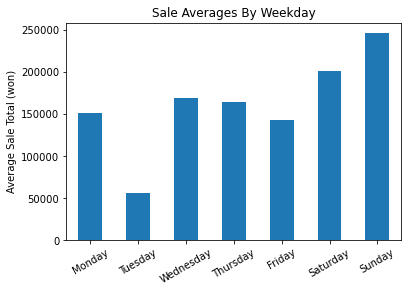

In [9]:
# investigating potential periodic trend in weekday sales
# calculate weekday sales averages
weekday_sales = non_rev_daily_sales[['total']].copy()
weekday_sales['weekday'] = weekday_sales.index.day_name()
weekday_totals = weekday_sales.groupby('weekday').total.mean()

# plot averages
day_order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
ax = weekday_totals.loc[day_order].plot(kind="bar", legend=False, rot=30)
plt.title('Sale Averages By Weekday')
plt.ylabel('Average Sale Total (won)')
plt.xlabel('')
plt.show()

**Sale Averages By Weekday**:
- Sunday has highest average sale amount, followed by Saturday
- Rest of usual business days about even with one another
- Friday has lowest average sale amount but not much less than other non-weekend days

## Overall Takeaways - Changes in Daily Revenue
1. **Delivery sales amounts over time generally trends flat with some days higher and some days lower**
2. **Delivery sales totals are generally higher on weekends than on weekdays**
3. **The high-delivery period from Mid-February to Mid-March coincides with South Korean pandemic response measures**
4. **In the month following the high-delivery period, delivery sales slowly return to pre-pandemic numbers**

# 2. Calculate exact delivery fee for each transaction
1. In non-aggregated sales dataframe, multiply item counts and item prices
2. Subtract this amount from the total transaction charge
3. Append this column of remaining charges (assumed as delivery charge) to dataframe

In [10]:
# 1.
# match up sales columns and prices list
# check lists to match up items and prices
print('Sales columns before fixes:')
print(sales.columns[3:].tolist())
print('')
print('Before fixes, Sales item columns match Prices item column:', (sales.columns[3:].tolist() == 
                                                                     prices.Name.tolist()))
# make adjustments
prices.loc[3,'Name'] = 'americano'
prices.loc[5, 'Name'] = 'caffe latte'
sales = sales.drop(columns=['croque monsieur','mad garlic'])
prices.loc[10, 'Name'] = 'milk tea'
prices.loc[17, 'Name'] = 'vanila latte'
prices = prices.drop(21)

# check adjustments
print('')
print('After fixes, Sales item columns match Prices item column:', (sales.columns[3:].tolist() == 
                                                                    prices.Name.tolist()))

Sales columns before fixes:
['angbutter', 'plain bread', 'jam', 'americano', 'croissant', 'caffe latte', 'tiramisu croissant', 'cacao deep', 'pain au chocolat', 'almond croissant', 'croque monsieur', 'mad garlic', 'milk tea', 'gateau chocolat', 'pandoro', 'cheese cake', 'lemon ade', 'orange pound', 'wiener', 'vanila latte', 'berry ade', 'tiramisu', 'merinque cookies']

Before fixes, Sales item columns match Prices item column: False

After fixes, Sales item columns match Prices item column: True


In [11]:
# create new dataframe where item counts are substituted by count * price
# adjust prices dataframe
prices_item_index = prices.copy()
prices_item_index.index = prices_item_index.Name
prices_item_index.drop(columns=['Name'], inplace=True)

# create charge substitution dataframe, substitute count for item charges
using_item_charges = sales.copy()
for col in sales.columns[3:]:
    item_price = int(prices_item_index[prices_item_index.index == col].price.item())
    using_item_charges[col] = sales[col] * item_price

# check work
using_item_charges.sample(3, random_state=1)

,day of week,total,place,angbutter,plain bread,jam,americano,croissant,caffe latte,tiramisu croissant,...,gateau chocolat,pandoro,cheese cake,lemon ade,orange pound,wiener,vanila latte,berry ade,tiramisu,merinque cookies
datetime,,,,,,,,,,,,,,,,,,,,,
2020-02-28 12:57:00,Fri,19600.0,후평 2동,9600.0,3500.0,NaN,NaN,NaN,NaN,4800.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-03-14 13:52:00,Sat,21800.0,후평 2동,4800.0,3500.0,NaN,NaN,3500.0,NaN,4800.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-10-05 12:39:00,Sat,31800.0,퇴계동,4800.0,NaN,NaN,NaN,3500.0,NaN,9600.0,...,NaN,NaN,NaN,NaN,4500.0,NaN,NaN,NaN,NaN,NaN


In [12]:
# 2.
# new column 'items_charge' in original dataframe which sums new dataframe's charges row-wise
sales['items_charge'] = using_item_charges.drop(columns=['day of week','total','place']).sum(axis=1)
# check work
sales[['total','items_charge']].head(4)

,total,items_charge
datetime,,
2019-07-11 15:35:00,23800.0,27700.0
2019-07-11 16:10:00,15800.0,14100.0
2019-07-13 13:19:00,14800.0,12800.0
2019-07-13 13:22:00,15600.0,14400.0


In [13]:
# 3.
# new column 'delivery_charge' which subtracts 'items_charge' from 'total'
sales['delivery_charge'] = sales['total'] - sales['items_charge']
# check work 
(sales[['total','items_charge','delivery_charge']].delivery_charge < 0).sum()

22

22 transactions show a negative delivery amount. **This is likely due to discounts.** Since we don't have discount information, our delivery amount analysis will be slightly degraded- but this analysis should still prove valuable thanks to the overall observation count.

# 3. Analyze delivery fee in the context of delivery location
1. Group each transaction's delivery fees by location (average)
2. Check minimum and maximum delivery fee by location
    * Based on unusual delivery fees, we can't verify minimum and maximum.
3. Check distribution of delivery fee by location if delivery fee varies
4. If fee varies, and distribution isn't even:
    * Try to locate the bakery in the city
    * Check distances from the bakery to the neighborhoods
    
## Neighborhood Translations and Locations
Standard Delivery Charge: 2000 won

**Chuncheon Center:**
- '조운동' 'Joundong' - Center of Chuncheon Neighborhoods - Standard Delivery Charge

**Inner Ring Around Joundong:**
- '약사명동' 'Yaksamyeongdong' - West of Joundong - Standard Delivery Charge
- '효자 1동' 'Hyoja 1' - Southwest of Joundong - Standard Delivery Charge
- '효자 2동' 'Hyoja 2' - South of Joundong - Standard Delivery Charge
- '효자 3동' 'Hyoja 3' - Southeast of Joundong - Standard Delivery Charge
- '교동' and '교동 ' 'Gyodong' - Northeast of Joundong - Standard Delivery Charge
- '소양동' 'Soyangdong' - Northwest of Joundong - Standard Delivery Charge

**Outer North and South of Joundong:**
- '근화동' 'Geunhwadong' - Northwest of Joundong Ring - *Higher* Delivery Charge
- '퇴계동' 'Toegyedong' - South of Joundong Ring - *Higher* Delivery Charge
- '석사동' 'Seoksadong' - Southeast of Joundong Ring - *Higher* Delivery Charge
- '후평 2동' 'Hupyeong 2' - East of Joundong Ring - Standard Delivery Charge
- '후평 3동' 'Hupyeong 3' - East edge of Hupyeong 2 - Standard Delivery Charge
- '후평 1동' 'Hupyeong 1' - Northeast of Joundong Ring - Standard Delivery Charge

**Far Reaches of Chuncheon:**
- '신사우동' 'Sinsaudong' - North - **Highest** Delivery Charge
- '강남동' 'Gangnamdong' - West - *Higher* Delivery Charge
- '신동면' 'Sindongmyeon' - South - No Delivery Charge (the single observation has item charge equal to total charge)
- '동내면' 'Dongnaemyeon' - Southeast - *Higher* Delivery Charge
- '동면' 'Dongmyeong' - Northeast - Standard Delivery Charge

Translating Korean characters to romanized Korean...

In [14]:
# convert korean characters to romanized korean
sales = sales.replace({'조운동':'Joundong', '약사명동':'Yaksamyeongdong', 
                       '효자 1동':'Hyoja 1', '효자 2동':'Hyoja 2', '효자 3동':'Hyoja 3', 
                       '교동':'Gyodong', '교동 ':'Gyodong', '소양동':'Soyangdong', 
                       '근화동':'Geunhwadong', '퇴계동':'Toegyedong', '석사동':'Seoksadong',
                       '후평 1동':'Hupyeong 1', '후평 2동':'Hupyeong 2', '후평 3동':'Hupyeong 3', 
                       '신사우동':'Sinsaudong', '강남동':'Gangnamdong', '신동면':'Sindongmyeon',
                       '동내면':'Dongnaemyeon','동면':'Dongmyeong'})

# check work
print(sales.place.value_counts().index)

Index(['Dongmyeong', 'Hupyeong 2', 'Hupyeong 3', 'Hupyeong 1', 'Seoksadong',
       'Hyoja 2', 'Toegyedong', 'Soyangdong', 'Sinsaudong', 'Hyoja 3',
       'Gyodong', 'Hyoja 1', 'Gangnamdong', 'Joundong', 'Geunhwadong',
       'Dongnaemyeon', 'Yaksamyeongdong', 'Sindongmyeon'],
      dtype='object')


Check average delivery fees by location...

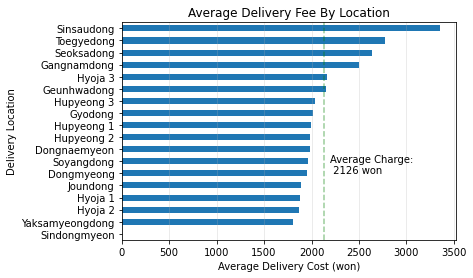

In [15]:
# 1. 
# group location by average delivery fee
sales.groupby('place').delivery_charge.mean().sort_values().plot.barh()
plt.axvline(sales.delivery_charge.mean(), c='green', alpha=.4, ls='--')
plt.title('Average Delivery Fee By Location')
plt.xlabel('Average Delivery Cost (won)')
plt.ylabel('Delivery Location')
plt.grid(axis='x', alpha=.3)
plt.text(2200, 5, f'Average Charge: \n {int(sales.delivery_charge.mean())} won')
plt.show()

Check boxplots of delivery fees...

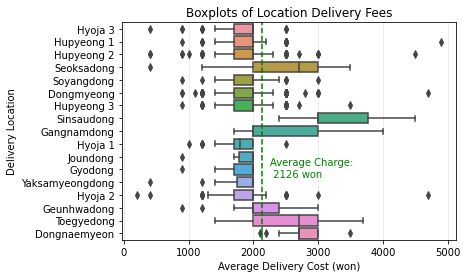

In [16]:
# 2.
# check boxplots for locations and delivery charges
mask = (sales.delivery_charge > 0) & (sales.delivery_charge < 5000) # remove outliers for overview
sns.boxplot(data=sales[mask], y='place', x='delivery_charge') # boxplots
plt.title('Boxplots of Location Delivery Fees')
plt.axvline(sales.delivery_charge.mean(), c='green', ls='--') # plot average delivery amount
plt.text(2250, 11.6, f'Average Charge: \n {int(sales.delivery_charge.mean())} won', c='green') # add text
plt.xlabel('Average Delivery Cost (won)')
plt.ylabel('Delivery Location')
plt.grid(axis='x', alpha=.3)
plt.show()

Based on previous analysis suggesting Sinsaudong has the highest overall revenue, I'm now realizing **we need to control for overall charges** in our delivery charge analysis. In order to do this, we will:
- Create a new column that contains the ratio of delivery charge against item charges
- Plot ratios in new boxplots
- Continue analysis using the ratios

Create new column for delivery fee ratio (delivery fee / total charge)...

In [17]:
# create new delivery_charge_ratio column for delivery charge divided by total charges
sales['delivery_charge_ratio'] = round(sales['delivery_charge'] / sales['total'], 3)
# check work
sales.delivery_charge_ratio.sample(5, random_state=1)

datetime
2020-02-28 12:57:00    0.087
2020-03-14 13:52:00    0.078
2019-10-05 12:39:00    0.060
2019-08-30 14:13:00    0.125
2019-09-08 11:37:00    0.065
Name: delivery_charge_ratio, dtype: float64

Boxplots for delivery fee ratios...

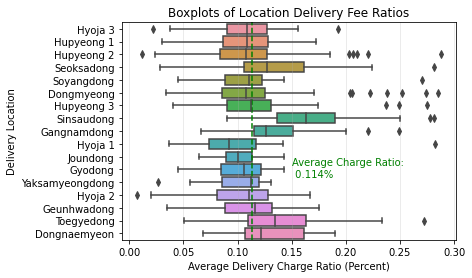

In [18]:
# 2.
# boxplots for delivery charge ratios
mask = (sales.delivery_charge_ratio > 0) & (sales.delivery_charge_ratio < .3) # remove outliers for overview
sns.boxplot(data=sales[mask], y='place', x='delivery_charge_ratio') # boxplots
plt.title('Boxplots of Location Delivery Fee Ratios')
plt.axvline(sales.delivery_charge_ratio.mean(), c='green', ls='--') # plot average delivery amount
plt.text(.15, 11.6, f'Average Charge Ratio: \n {round(sales.delivery_charge_ratio.mean(),3)}%', c='green') # add text
plt.xlabel('Average Delivery Charge Ratio (Percent)')
plt.ylabel('Delivery Location')
plt.grid(axis='x', alpha=.3)
plt.show()

----------------------------------------Hyoja 3----------------------------------------


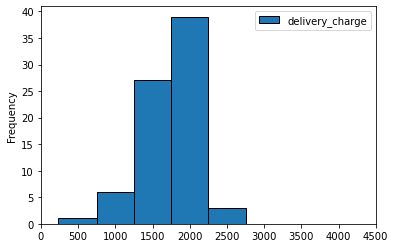

----------------------------------------Hupyeong 1----------------------------------------


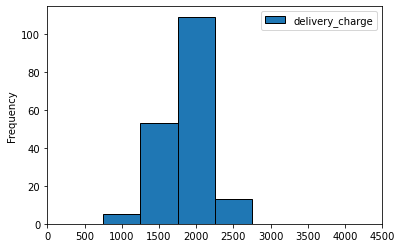

----------------------------------------Hupyeong 2----------------------------------------


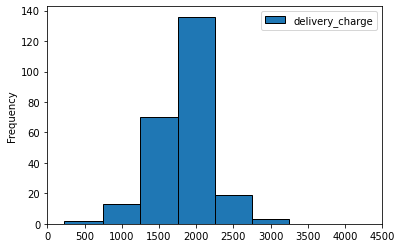

----------------------------------------Seoksadong----------------------------------------


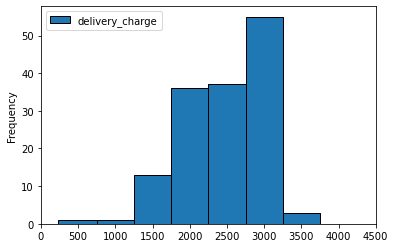

----------------------------------------Soyangdong----------------------------------------


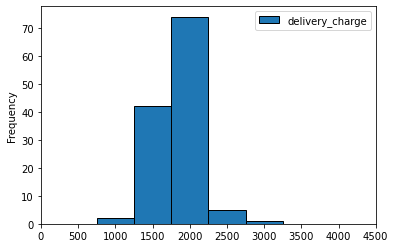

----------------------------------------Dongmyeong----------------------------------------


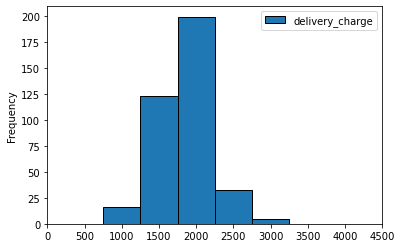

----------------------------------------Hupyeong 3----------------------------------------


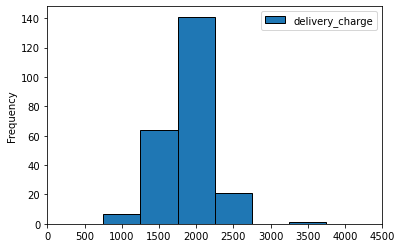

----------------------------------------Sinsaudong----------------------------------------


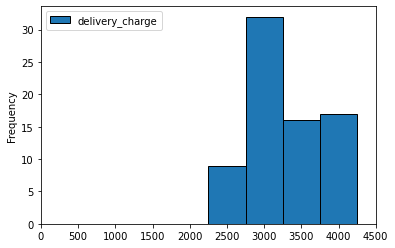

----------------------------------------Gangnamdong----------------------------------------


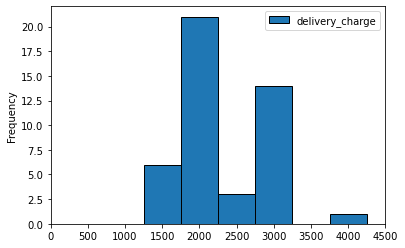

----------------------------------------Hyoja 1----------------------------------------


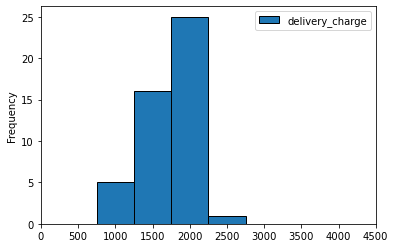

----------------------------------------Joundong----------------------------------------


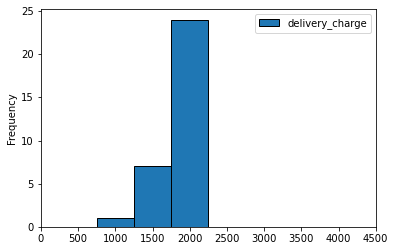

----------------------------------------Toegyedong----------------------------------------


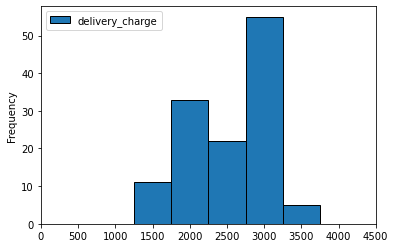

----------------------------------------Gyodong----------------------------------------


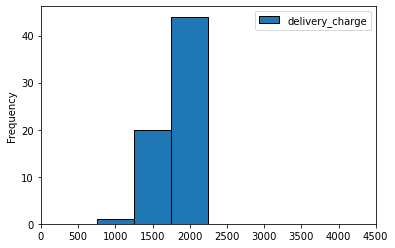

----------------------------------------Yaksamyeongdong----------------------------------------


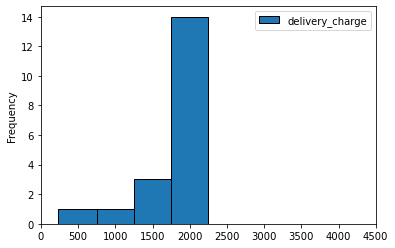

----------------------------------------Hyoja 2----------------------------------------


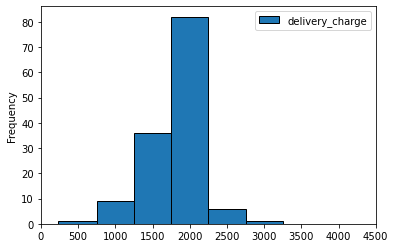

----------------------------------------Geunhwadong----------------------------------------


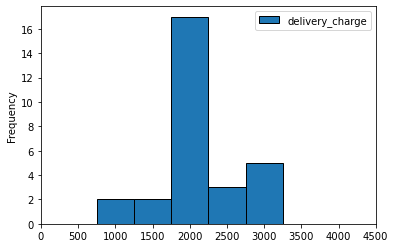

----------------------------------------Dongnaemyeon----------------------------------------


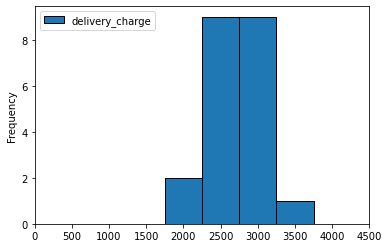

----------------------------------------Sindongmyeon----------------------------------------


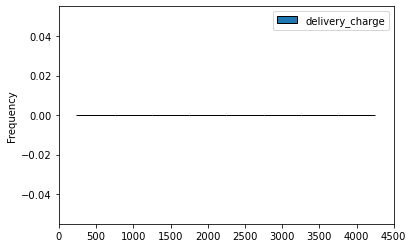

In [19]:
# 3. 
# plot histograms for each location for the delivery fees
for location in sales.place.unique()[1:]:
    print('-'*40 + location + '-'*40)
    mask = (sales.place == location)
    binwidths = [225,750,1250,1750,2250,2750,3250,3750,4250]
    sales[mask][['place','delivery_charge']].plot.hist(bins=binwidths, ec='black')
    plt.xlim([0,4500])
    plt.show()

**Histogram takeaways (distribution observations):**
- Note: Each number indicates the delivery charge
- Note: Each letter indicates small amount (s), medium amount (m), or large amount (l) of that delivery charge

Close to bakery:
- Yaksamyeongdong: 500 s, 1000 s, 1500 s, **2000 l**
- Joundong: 1000 s, *1500 m*, **2000 l**
- Gyodong: 1000 s, *1500 m*, **2000 l**
- Hyoja 1: 1000 s, *1500 m*, **2000 l**, 2500 s
- Hyoja 2: 500 s, 1000 s, *1500 m*, **2000 l**, 2500 s, 3000 s
- Hyoja 3: 1000 s, *1500 m*, **2000 l**, 2500 s
- Hupyeong 1: 1000 s, *1500 m*, **2000 l**, 2500 s
- Hupyeong 2: 1000 s, *1500 m*, **2000 l**, 2500 s, 3000 s
- Hupyeong 3: 1000 s, *1500 m*, **2000 l**, 2500 s, 3500 outlier
- Soyangdong: 1000 s, *1500 m*, **2000 l**, 2500 s, 3000 s
- Dongmyeong: 1000 s, *1500 m*, **2000 l**, 2500 s, 3000 s

Medium-range from bakery:
- Gangnamdong: 1500 s, **2000 l**, 2500 s, *3000 m*, no 3500, 4000 s
- Geunhwadong: 1000 s, 1500 s, **2000 l**, 2500 s, *3000 m*

Far from bakery:
- Seoksadong: 1000 s, 1500 s, *2000 m*, *2500 m*, **3000 l**, 3500 s
- Toegyedong: 1500 s, *2000 m*, *2500 m*, **3000 l**, 3500 s
- Dongnaemyeon: 2000 s, *2500 l*, **3000 l**, 3500 s
- Sinsaudong: 2500 s, **3000 l**, *3500 m*, **4000 m**

**Bakery location: Between Yaksamyeong and Hyoja 2**

## Takeaways
- Calculating delivery fee and grouping by location can be used for triage of the origin area
- Based on delivery fees, we have grouped delivery locations in terms of close, medium, and far delivery
- Using these groupings, we may be able to create features that help predict sales charges

In [20]:
# 4.
# if the distribution indicates a sub-location pricing,
# use location delivery fee averages to get a general location of the bakery (larger average fee = more distant)
# select close, medium, and far bins for each location to get sub-location information for each transaction

# 4. Understand delivery locations and their trends
## Do certain areas order during a certain time of day?
1. Bin business time by hour
2. Create crosstab of place and hour for count of transactions
3. Check for anomalies

In [21]:
# 1.
# create bins for each hour in the day in new column (transaction happened in hour 0, hour 1, ... hour 23)
# plot distribution of each hour's number of transactions (value counts)

In [22]:
# 2.
# create crosstab of location column and transaction_hour column for all transactions

In [23]:
# 3.
# markdown: capture anything noteworthy

## Do certain areas purchase more items on average?
1. Sum total item counts by transaction in new column
2. Group by location for total item counts (average)

In [24]:
# 1.
# use individual transaction dataframe to sum row-wise in 'total_items' column
# group by location on 'total_items' column (average)

## Do certain areas purchase more in terms of revenue?
1. Group by location for total transaction costs (sum totals)
2. Group by location for total transaction costs (average)

In [25]:
# 1.
# group by location for total charges (sum totals)

In [26]:
# 2.
# group by location for total charges (average)

## Did certain areas have increased/decreased activity weeks or months?
1. Plot each location's total charges over time
2. Plot each location's total item counts over time

In [27]:
# 1.
# new column in individual transaction dataframe for binned transaction week 
# (transaction in week 1, 2, ... final week)
# group by week in terms of total charges
# plot line chart for each location in terms of weekly totals
# group by month in terms of total charges (index.month)
# plot line chart for each location in terms of monthly totals

In [28]:
# 2.
# group by week in terms of total item counts
# plot line chart for each location in terms of weekly item totals
# group by month in terms of total item counts (index.month)
# plot line chart for each location in terms of monthly item totals

## Do certain areas purchase more of an item than others?
1. For each item, group location for total purchases of that item
2. Plot location and each total amount purchased of that item

In [29]:
# 1.
# iterate through item columns, group location in terms of count of the item column
# for each item, plot bar chart for total purchases (x axis is location)

# 5. Analyze how products sold
## Which items sold the most? Which items sold the least? Which item had the highest revenue?
1. Sum item columns' counts
2. Find highest and lowest three counts
3. Multiply item totals by prices
4. Determine top-three-revenue items

In [30]:
# 1.
# column-wise sum of item counts

In [31]:
# 2.
# sort by count, get head 3 and tail 3

In [32]:
# 3.
# multiply each item count sum by the respective price of the item

In [33]:
# 4.
# note top-3 revenue items

## Are there significant increases or decreases in certain items sold during holidays or otherwise?
1. Use previous list of major events to select certain days
2. Check average sales of each item for week prior and week ahead (if week does not end up on another holiday)
3. Compare average sales of week prior and week ahead to the day in question for each item

In [34]:
# 1.
# select each eventful day

In [35]:
# 2.
# calculate week prior and week ahead averages for each item's total sale counts

In [36]:
# 3.
# compare week prior and week ahead averages to the event day's total

## Are any items being disproportionately bought by certain areas?
1. Check each item's total sales for each area
2. Calculate each area's total item sales
3. Calculate proportion of individual totals to grand total
4. Compare proportions for each area to see if there's high or low purchase numbers proportionately

In [37]:
# 1.
# iterate through each item and each location
# store location and bought-amount for each item

In [38]:
# 2.
# calculate total item sales count by location

In [39]:
# 3.
# for each location, divide total item sales by each specific item's counts
# store location and each item's sale proportions

In [40]:
# 4.
# compare proportions on each item+location combination
# note places with high or low proportions

# 6. Create a Tableau heatmap for locations and sales
1. If not done in section 3 step 4:
    * Figure out general location of bakery
    * Figure out general areas of the bakery's delivery locations
2. Map bakery and delivery locations in a clear way
3. Heatmap each boundary box in terms of sales revenue
    * Also consider controlling for delivery charge or displaying delivery charge in context display
4. Heatmap each boundary box in terms of specific item sale counts

In [41]:
# markdown: put work here